In [1]:
from env import TestEnv
from executor import Executor
from trace import Trace
import json

In [2]:
from conf import LisaLogging
import logging
# LisaLogging.setup(level=logging.WARNING)

# Run a workload

In [3]:
te = TestEnv({
    'platform': 'android',
    'board': 'pixel',
    'rtapp-calib': {"0": 104, "1": 106, "2": 78, "3": 78}
}, test_conf = {
    'ftrace': {
        'events': ['sched_switch', 'cpu_idle', 'irq*']
    },
    'modules': ['cgroups']
})

In [4]:
executor = Executor(te, {
    'confs': [{'tag': 'myconf', 'flags': ['ftrace', 'freeze_userspace']}],
    'wloads': {    
        'one_small' : {
            'type' : 'rt-app',
            'conf' : {
                'class' : 'periodic',
                'params' : {
                    'duty_cycle_pct': 20,
                    'duration_s': 2,
                    'period_ms': 10,
                },
                'tasks' : 1,
                'prefix' : 'many',
            },
        },
    }
})

In [5]:
executor.run()

No handlers could be found for logger "Executor"


# Parse captured ftrace

In [6]:
from trappy.plotter import plot_trace

In [7]:
with open('EnergyModel/pixel.json') as js:
    pixel = json.load(js)

In [8]:
trace = Trace(pixel, executor.experiments[0].out_dir, ['sched_switch', 'cpu_idle', 'irq_handler_entry'])

In [9]:
plot_trace(trace.ftrace)

# Get `irq_handler_entry` event

In [ ]:
trace.available_events

In [10]:
irq = trace.data_frame.trace_event('irq_handler_entry')

# Examine IRQ frequency

In [13]:
import pandas as pd
%matplotlib inline

In [14]:
import matplotlib.pyplot as plt

In [15]:
def plot_irqs(irqs):
    evt_difference = irqs.index[1:] - irqs.index[:-1]
    df = pd.DataFrame({'time_delta': evt_difference, 'time': irqs.index[1:]})
    fig, axs = plt.subplots(1,2)
    df.plot(kind='scatter', x='time', y='time_delta', figsize=(10, 4), ax=axs[0])
    df.time_delta.plot(kind='hist', bins=70, ax=axs[1])

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


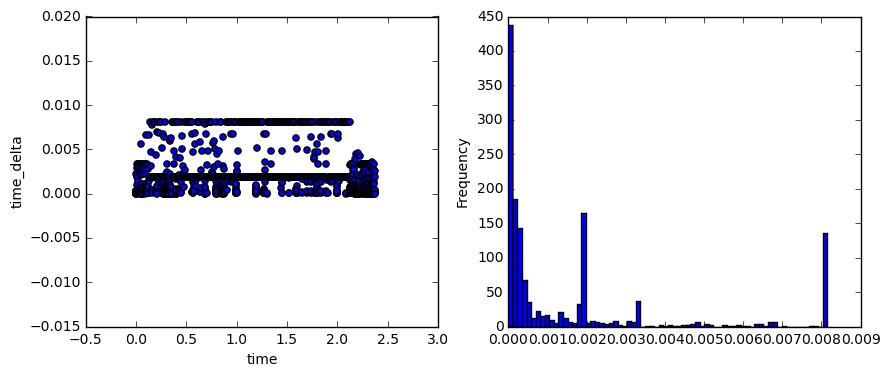

In [16]:
plot_irqs(irq)

In [17]:
irq_cpu1 = irq[irq['__cpu'] == 1]

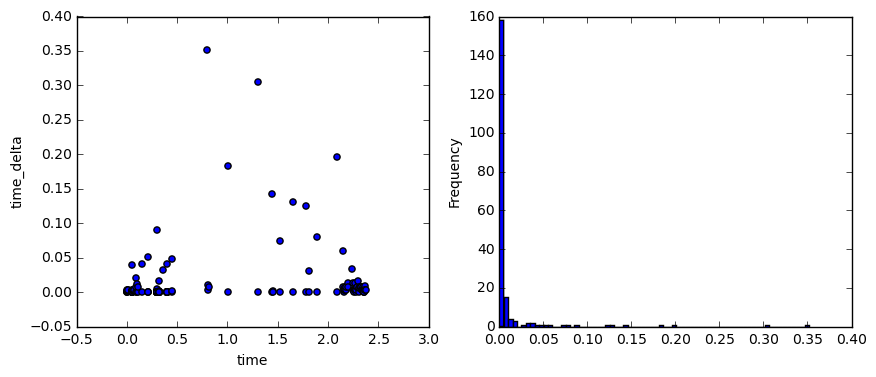

In [18]:
plot_irqs(irq_cpu1)

In [19]:
irq['name'].unique()

array(['qcom,smd-rpm', 'qcom,glink-smem-native-xprt-rpm', 'dwc3',
       'arch_timer', '408000.qcom,cpu-bwmon', 'cpr3', 'arch_mem_timer',
       'wlan_pci', 'nanohub-irq2', 'nanohub-irq1', 'sps', 'ufshcd',
       'VSYNC_GPIO', 'arm-pmu'], dtype=object)

In [20]:
some_irq = irq[irq['name'] == 'arch_timer']

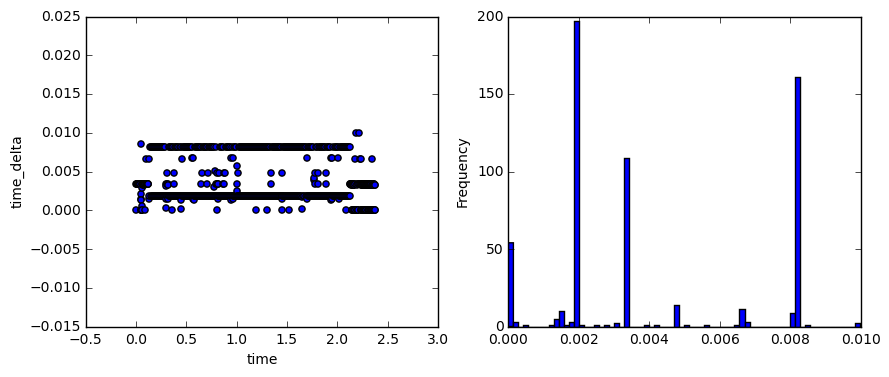

In [21]:
plot_irqs(some_irq)